# Satellite images editing

This notebook was used for editing and preprocessing the satellite images.

**<span style="color:red">Attention!</span>**
\
Don't run the whole notebook to avoid making not needed changes. Run each cell separately.

In [1]:
# move to root directory

%cd c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided

c:\Users\mathi\Desktop\TU Delft\TU Delft year 5\Data_science\Morphology_project\jamunet-morpho-braided


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from osgeo import gdal

from preprocessing.satellite_analysis_pre import *

In [3]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

Set default visualization parameters for grayscale images (suited only for JRC dataset). If RGB images are displayed or images from other collections these should be manually adjusted.

In [4]:
plt.rcParams['image.cmap'] = 'gray'
vmin = 0
vmax = 2

In [5]:
train = 'training'

Directories of original and preprocessed images. 

In [6]:
# Set river
rivers = ['Jamuna','Ganges', 'Indus', 'Ghangara']
river = rivers[3]  # change index to select different rivers

base_dir= os.path.join('data', 'satellite', f'{river}_images')
orig_dir = os.path.join(base_dir, 'original')
preproc_dir = os.path.join(base_dir, 'preprocessed')

print(base_dir)
print(orig_dir)
print(preproc_dir)

data\satellite\Ghangara_images
data\satellite\Ghangara_images\original
data\satellite\Ghangara_images\preprocessed


### 2. Preprocess all images of a reach 

All images from training reaches are preprocessed, including reshaping to make sure their shape is <code>(1000, 500)</code> pixels (or else if specified) and a rigid rotation (of 45° or 90°) to ensure the flow is directed southward (from the top to the bottom of the image).
\
Training, validation, and testing reaches are preprocessed in different cells. 

In [27]:
import os
import cv2
import numpy as np
from osgeo import gdal
from scipy.ndimage import rotate

# ==========================================
# 1. CONFIGURATION & DICTIONARIES
# ==========================================

# POINT THIS TO THE PARENT FOLDER containing 'original' and 'preprocessed'
base_directory = base_dir

# Define your rotation angles (Fill these based on your visual check!)
reach_angles = {
    'r1': 45, 
    'r2': 45, 
    'r3': 0, 
    'r4': 0, 
    'r5': 0, 
    'r6': 0, 
    'r7': 0, 
    'r8': 0, 
    'r9': 0, 
    'r10': 0, 
    'r11': 0, 
    'r12': 45,
    'r13': 45,
    'r14': 45,
    'r15': 45
}

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def get_fixed_angle(reach_id):
    """Returns the manual rotation angle for a specific reach."""
    return reach_angles.get(reach_id, 0)

def rotate_images(image, reach_id, reshape_img=True):
    """Rotates based on Reach ID lookup table."""
    angle = get_fixed_angle(reach_id)
    # Order 0 = Nearest Neighbor (preserves integer classes)
    rotated_image = rotate(image, angle, reshape=reshape_img, order=0)
    return np.round(rotated_image, 0)

def reshape_images(image, desired_shape=(1000,500), new_padded_class=None):
    """Reshapes image with padding/cropping."""
    current_shape = np.shape(image)
    
    # 1. Height Check
    if current_shape[0] > desired_shape[0]:
        top = (current_shape[0] - desired_shape[0]) // 2
        bottom = top + desired_shape[0]   
    else:
        top = 0
        bottom = current_shape[0]
        
    # 2. Width Check
    if current_shape[1] > desired_shape[1]:
        left = (current_shape[1] - desired_shape[1]) // 2
        right = left + desired_shape[1]
    else:
        left = 0
        right = current_shape[1] # <--- FIX: Used to be [0], now [1] for Width
    
    # Crop center
    cropped_image = image[top:bottom, left:right]
    
    # Create padded canvas
    padded_image = np.zeros(desired_shape, dtype=image.dtype)
    if new_padded_class is not None:
        padded_image[:,:] = new_padded_class

    # Calculate padding offsets
    v_pad = (desired_shape[0] - cropped_image.shape[0]) // 2
    h_pad = (desired_shape[1] - cropped_image.shape[1]) // 2

    # Place image
    padded_image[v_pad:v_pad+cropped_image.shape[0], h_pad:h_pad+cropped_image.shape[1]] = cropped_image

    return padded_image

def preprocess_images(input_path, reach_id, desired_shape=(1000,500), reshape_img=True, 
                      new_padded_class=None, input_f='original', output_f='preprocessed'):
    
    # 1. Load Image
    img_ds = gdal.Open(input_path)
    if img_ds is None:
        print(f"Skipping broken file: {input_path}")
        return
    img_array = img_ds.ReadAsArray()

    # 2. Rotate (Passing reach_id now)
    img_rot = rotate_images(img_array, reach_id, reshape_img)
    
    # 3. Reshape
    img_resh = reshape_images(img_rot, desired_shape, new_padded_class)

    # 4. Save to Output Directory
    # This logic keeps the folder structure (original -> preprocessed)
    # os.path.dirname gives: ...\Ghanghara_images\original\month_1\reach_r1
    # .replace changes it to: ...\Ghanghara_images\preprocessed\month_1\reach_r1
    
    filename = os.path.basename(input_path)
    output_dir = os.path.dirname(input_path).replace(input_f, output_f)
    output_path = os.path.join(output_dir, filename)

    os.makedirs(output_dir, exist_ok=True) # Automatically creates month_X/reach_X folders
    cv2.imwrite(output_path, img_resh)

# ==========================================
# 3. EXECUTION LOOP
# ==========================================

if not os.path.exists(orig_dir):
    print(f"Error: Could not find 'original' folder at: {orig_dir}")
else:
    # Loop over Months (month_1, month_2...)
    for month_folder_name in os.listdir(orig_dir):
        month_path = os.path.join(orig_dir, month_folder_name)
        
        # Skip random files, only process directories
        if not os.path.isdir(month_path): 
            continue

        print(f'Started preprocessing "{month_folder_name}"...')
        
        # Loop over Reaches (JRC_..._r1, JRC_..._r2...)
        for reach_folder_name in os.listdir(month_path):
            reach_path = os.path.join(month_path, reach_folder_name)
            
            if not os.path.isdir(reach_path):
                continue
                
            # Extract Reach ID (e.g., "r8") for rotation logic
            # Assumes folder ends with "_r8" or similar
            try:
                reach_id = reach_folder_name.split('_')[-1]
            except:
                reach_id = 'unknown' # Will default to 0 rotation
            
            # Loop over Images
            for image_name in os.listdir(reach_path):
                if not image_name.endswith('.tif'): 
                    continue
                    
                full_input_path = os.path.join(reach_path, image_name)
                
                # Run the pipeline
                preprocess_images(full_input_path, reach_id=reach_id)
                
        print(f'Finished "{month_folder_name}"!')

Started preprocessing "month_1"...
Finished "month_1"!
Started preprocessing "month_2"...
Finished "month_2"!
Started preprocessing "month_3"...
Finished "month_3"!
Started preprocessing "month_4"...
Finished "month_4"!


In [28]:
# # Training reaches
# for folder in os.listdir(directory):

#     print(fr'Started preprocessing folder "{folder}"...')
#     month_folder = os.path.join(directory, str(folder))
#     for reach in os.listdir(month_folder):

#         print(fr'Started preprocessing folder "{reach}"...')
#         reach_folder = os.path.join(month_folder, str(reach))
#         for image in os.listdir(reach_folder):

#             full_path = os.path.join(reach_folder, image)
#             preprocess_images(full_path,) # do it for all images
#         print(fr'Finished preprocessing folder "{folder}"!')

In [29]:
# validation reaches
# for folder in os.listdir(dir_orig):
#     if val in folder: # loop only over validation reaches
#         print(fr'Started preprocessing folder "{folder}"...')
#         reach_folder = os.path.join(dir_orig, str(folder))
#         for image in os.listdir(reach_folder):
#             full_path = os.path.join(reach_folder, image)
#             preprocess_images(full_path) # do it for all images
#         print(fr'Finished preprocessing folder "{folder}"!')

In [30]:
# testing reaches
# for folder in os.listdir(dir_orig):
#     if test in folder: # loop only over testing reaches
#         print(fr'Started preprocessing folder "{folder}"...')
#         reach_folder = os.path.join(dir_orig, str(folder))
#         for image in os.listdir(reach_folder):
#             full_path = os.path.join(reach_folder, image)
#             preprocess_images(full_path) # do it for all images
#         print(fr'Finished preprocessing folder "{folder}"!')

## Evaluate pre-processed images

Choose a certain year to loop over all reaches

Looking in: data\satellite\Ghangara_images\preprocessed\month_3
Found 10 reach folders.


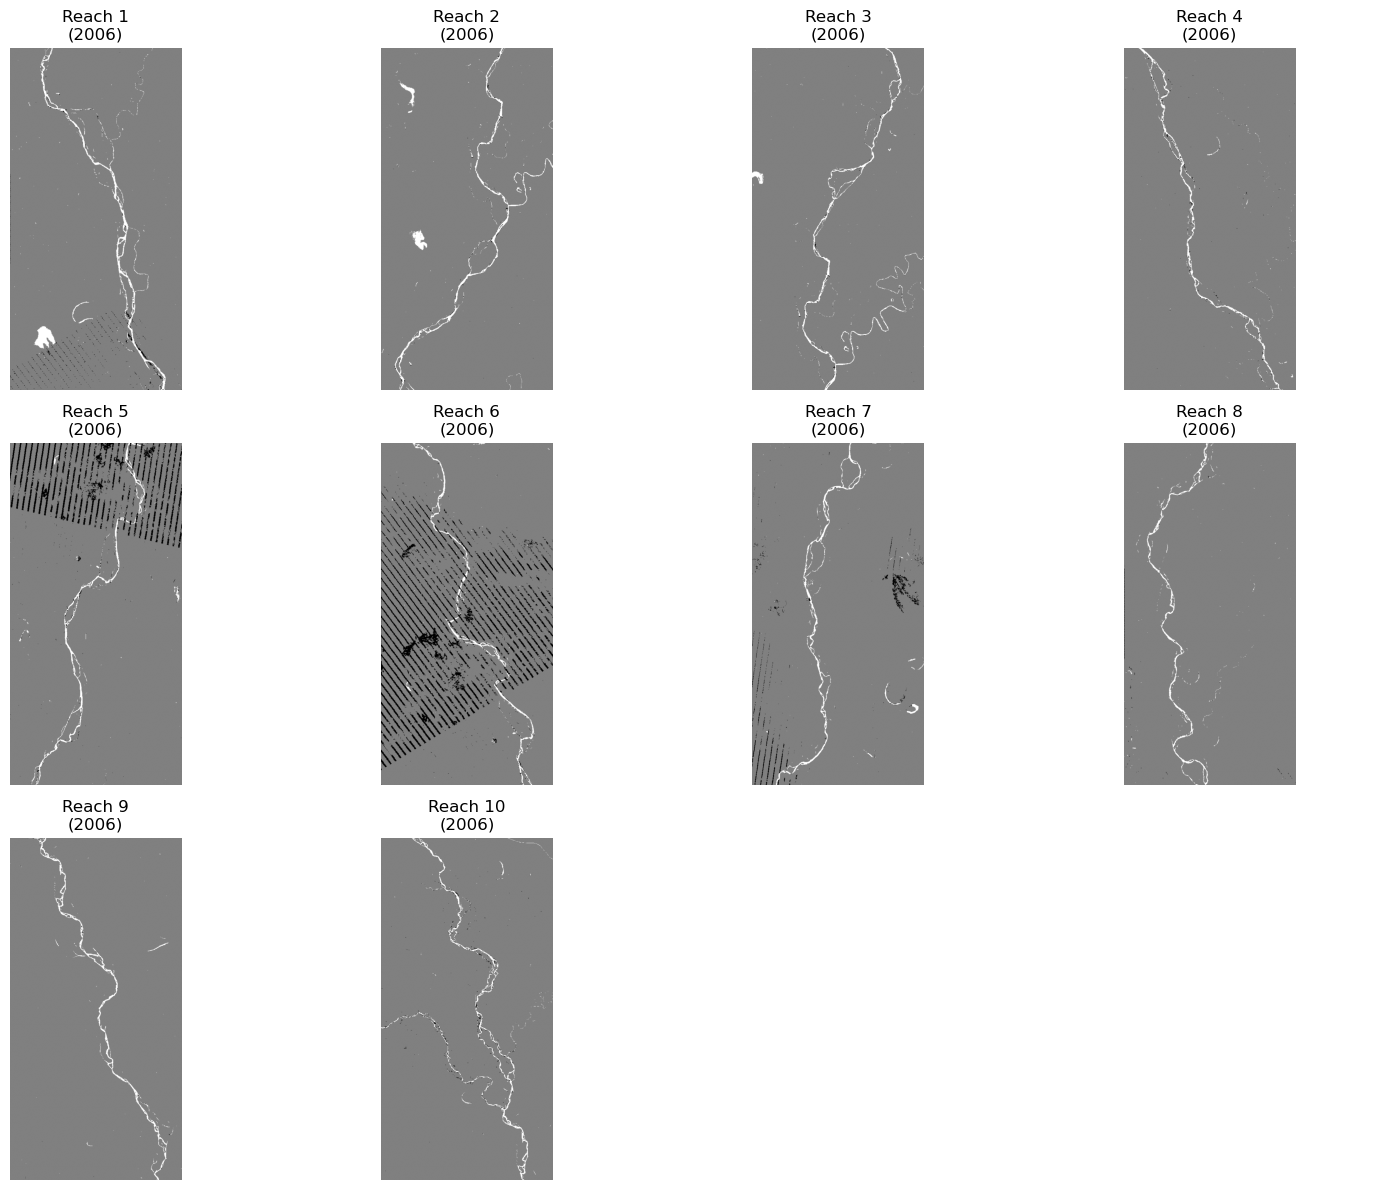

In [8]:
# --- CONFIGURATION ---
year = 2006   # Make sure this year actually exists in your data!
month = 3
vmin, vmax = 0, 2 # Ensure these are set for your data range
# ---------------------

month_dir = os.path.join(preproc_dir, f'month_{str(month)}')
print(f"Looking in: {month_dir}")

# 1. Get Reach Folders and Sort them intelligently
# We sort by the length of the name first, then the name, to ensure 'r2' comes before 'r10'
# or better yet, we extract the number.
def get_reach_num(folder_name):
    try:
        # Assumes folder ends in "_rX"
        return int(folder_name.split('_r')[-1])
    except:
        return 999

if not os.path.exists(month_dir):
    print("Month directory does not exist.")
else:
    # Get folders and sort them by reach number (r1, r2, ... r10)
    reach_folders = [f for f in os.listdir(month_dir) if os.path.isdir(os.path.join(month_dir, f))]
    reach_folders.sort(key=get_reach_num)
    
    num_reaches = len(reach_folders)
    print(f"Found {num_reaches} reach folders.")

    # 2. Setup Subplots
    cols = 4 
    rows = math.ceil(num_reaches / cols)
    
    if num_reaches == 0:
        print("No reaches found. Check your path.")
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axs = axs.flatten()

        # 3. Loop over the ACTUAL folders found
        for i, folder_name in enumerate(reach_folders):
            ax = axs[i]
            reach_num = get_reach_num(folder_name)
            reach_path = os.path.join(month_dir, folder_name)
            
            # Search for the .tif file for the specific YEAR
            # This handles slight naming variations automatically
            found_file = None
            for f in os.listdir(reach_path):
                if f.endswith('.tif') and str(year) in f:
                    found_file = f
                    break
            
            if found_file:
                full_path = os.path.join(reach_path, found_file)
                img_ds = gdal.Open(full_path)
                
                if img_ds:
                    img_array = img_ds.ReadAsArray()
                    ax.imshow(img_array, vmin=vmin, vmax=vmax)
                    ax.set_title(f"Reach {reach_num}\n({year})")
                else:
                    ax.text(0.5, 0.5, 'Corrupt File', ha='center', va='center', color='red')
            else:
                # File for that year not found
                ax.text(0.5, 0.5, f'Year {year}\nNot Found', ha='center', va='center', color='red')
                ax.set_title(f"Reach {reach_num}")

            ax.axis('off')

        # Cleanup empty subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.show()

Looking in: data\satellite\Ghangara_images\preprocessed\month_3\JRC_GSW1_4Monthlyhistory_Ghangara_03_r5
Found 23 years/files for JRC_GSW1_4Monthlyhistory_Ghangara_03_r5.


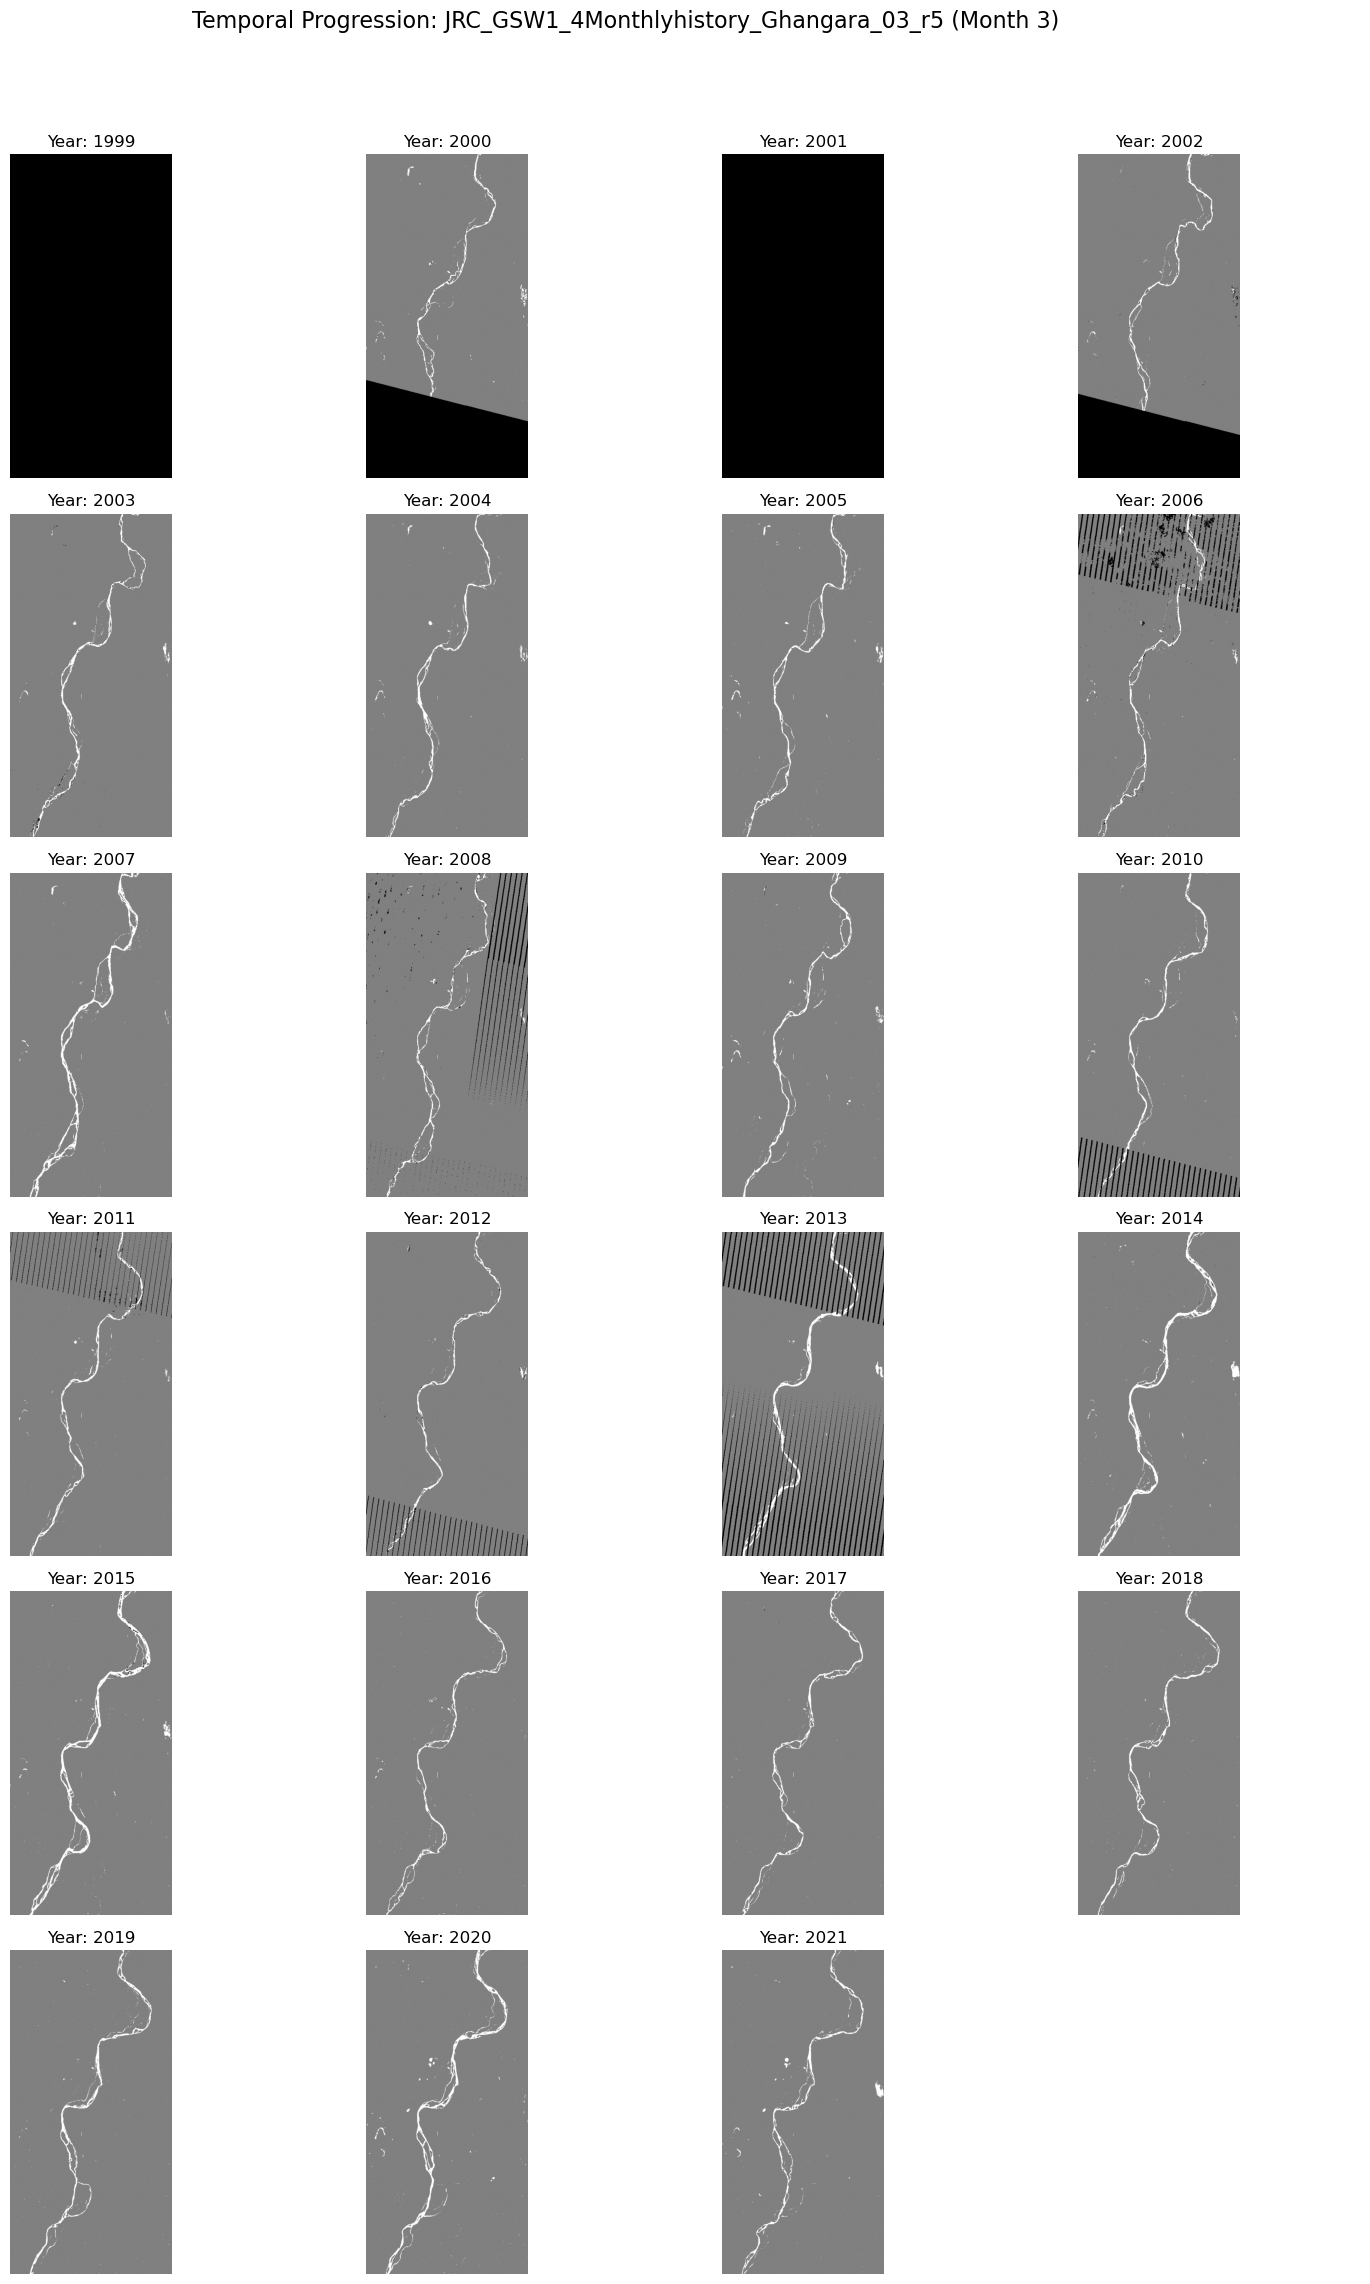

In [11]:
# --- CONFIGURATION ---
target_reach_folder = 'JRC_GSW1_4Monthlyhistory_Ghangara_03_r5'  # Change this to your specific reach folder name
month = 3
vmin, vmax = 0, 2 
# ---------------------

month_dir = os.path.join(preproc_dir, f'month_{str(month)}')
reach_path = os.path.join(month_dir, target_reach_folder)

print(f"Looking in: {reach_path}")

if not os.path.exists(reach_path):
    print(f"Error: Path {reach_path} does not exist.")
else:
    # 1. Gather all .tif files in that reach folder
    # We sort them so the years appear in chronological order
    tif_files = sorted([f for f in os.listdir(reach_path) if f.endswith('.tif')])
    
    num_years = len(tif_files)
    print(f"Found {num_years} years/files for {target_reach_folder}.")

    # 2. Setup Subplots
    cols = 4 
    rows = math.ceil(num_years / cols)
    
    if num_years == 0:
        print("No .tif files found in this reach folder.")
    else:
        # Dynamic figure height based on number of rows
        fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        
        # Flatten axs if more than 1, otherwise wrap it in a list
        if num_years > 1:
            axs = axs.flatten()
        else:
            axs = [axs]

        # 3. Loop over the FILES (years)
        for i, filename in enumerate(tif_files):
            ax = axs[i]
            
            # Attempt to extract the year from filename for the title
            # This assumes your filename contains a 4-digit year (e.g., "data_2006.tif")
            import re
            year_match = re.search(r'\d{4}', filename)
            year_label = year_match.group(0) if year_match else filename
            
            full_path = os.path.join(reach_path, filename)
            img_ds = gdal.Open(full_path)
            
            if img_ds:
                img_array = img_ds.ReadAsArray()
                # If your TIF has multiple bands, you might need: img_array[0]
                ax.imshow(img_array, vmin=vmin, vmax=vmax)
                ax.set_title(f"Year: {year_label}")
            else:
                ax.text(0.5, 0.5, 'Corrupt File', ha='center', va='center', color='red')
            
            ax.axis('off')

        # Cleanup empty subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.suptitle(f"Temporal Progression: {target_reach_folder} (Month {month})", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
        plt.show()

### 3. Calculate total amount of pixels for each class 

For each reach a <code>*.csv</code> file is created to store information on total number of pixels for each class.

**<span style="color:red">Attention!</span>**
\
There is no need to run the following cells because all <code>*.csv</code> files are already generated.

**<span style="color:red">Attention 2!</span>**
\
The next cells should be run after all images are preprocessed, in order to make sure these all have the same dimension and orientation.

In [39]:
# 1. Setup the main pixel_count directory
pixel_count_base = os.path.join(preproc_dir, 'pixel_count')
os.makedirs(pixel_count_base, exist_ok=True)

print(f"📂 Scanning: {preproc_dir}")

# 2. Loop through Months (month_1, month_2, etc.)
for month_name in os.listdir(preproc_dir):
    month_input_path = os.path.join(preproc_dir, month_name)
    
    # Check if it is a directory and ignore the new 'pixel_count' folder itself
    if not os.path.isdir(month_input_path) or month_name == 'pixel_count':
        continue

    print(f'Processing Month: {month_name}...')

    # Create a matching month folder inside pixel_count
    # Structure: preprocessed/pixel_count/month_1/
    month_output_path = os.path.join(pixel_count_base, month_name)
    os.makedirs(month_output_path, exist_ok=True)

    # 3. Loop through Reaches inside that month
    # Sort them to keep the print output clean
    reach_folders = sorted([f for f in os.listdir(month_input_path) if os.path.isdir(os.path.join(month_input_path, f))])

    for reach_folder_name in reach_folders:
        print(f'   > Counting pixels for "{reach_folder_name}"...')
        
        full_reach_input_path = os.path.join(month_input_path, reach_folder_name)
        
        # Extract the REAL Reach ID (e.g. "r8" from "JRC..._r8")
        try:
            reach_id = reach_folder_name.split('_')[-1] # Gets "r8"
        except:
            reach_id = "unknown"

        # Run the updated function
        save_tot_pixels(
            input_reach_folder=full_reach_input_path, 
            output_folder=month_output_path, 
            reach_id=reach_id,
            prefix='training' # You can change this to 'validation' etc. if needed
        )

    print(f'Finished Month: {month_name}!\n')

print("✅ All pixel counts saved.")

📂 Scanning: data\satellite\Indus_images\preprocessed
Processing Month: month_1...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r1"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r10"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r11"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r12"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r13"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r14"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r15"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r2"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r3"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r4"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r5"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r6"...
   > Counting pixels for "JRC_GSW1_4Monthlyhistory_Indus_01_r7"...
   > Counting pixels for "JRC_GSW1_4Month

### 4. Calculate the "average" image across a season (from January to April of the same year) 

For each reach a <code>*.csv</code> file is created to store the pixel value of the average image across a season. The average is used to replace `no-data` pixels of the imagse used in the datasets, and consequently create only binary images with two classes (`non-water` and `water`). 

**<span style="color:red">Attention!</span>**
\
The next cell was used to compute and save the season average image for al years and reaches by setting the default `window_size=15` and `replace_default=0`. There is no need to rerun the cell, unless different values are to be chosen.

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from osgeo import gdal

# --- CONFIGURATION ---
output_averages_dir = os.path.join(base_dir, 'averages')
# ---------------------

def season_average(train_val_test, reach, year, dir_datasets, nodata=-1):
    '''
    Computes average pixel values across the low-flow season (Jan-Apr).
    Refactored to read from the preprocessed structure.
    '''
    imgs = []
    
    # Loop Jan (1) to April (4)
    for month in range(1, 5):
        month_folder = os.path.join(dir_datasets, f'month_{month}')
        
        if not os.path.exists(month_folder):
            continue

        # Find the specific reach folder (e.g. "..._r8")
        target_reach_folder = None
        for f in os.listdir(month_folder):
            if f.endswith(f'_r{reach}'):
                target_reach_folder = f
                break
        
        if target_reach_folder is None:
            continue

        reach_path = os.path.join(month_folder, target_reach_folder)

        # Find images for the specific year
        for image_name in os.listdir(reach_path):
            if str(year) in image_name and image_name.endswith('.tif'):
                img_path = os.path.join(reach_path, image_name)
                
                # Read Image using GDAL
                ds = gdal.Open(img_path)
                if ds is None: continue
                img = ds.ReadAsArray()
                
                # Replace no-data with NaN
                img = img.astype(float)
                img[img == nodata] = np.nan
                imgs.append(img)
    
    if not imgs:
        return None

    # Compute pixel-wise average excluding NaN
    # FIXED: Use standard 'warnings' library instead of 'np.warnings'
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        avg_season = np.nanmean(imgs, axis=0)
        
    return avg_season

def replace_nan_with_neighbors_mean(image, window_size=15, replace_default=0):
    # (Kept identical to your logic)
    padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=np.nan)
    rows, cols = image.shape
    neigh_image = np.copy(image)

    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            if np.isnan(padded_image[i, j]):
                neighbors = padded_image[
                    i-(window_size//2):i+((window_size//2)+1), 
                    j-(window_size//2):j+((window_size//2)+1)
                ].flatten()

                valid_neighbors = neighbors[~np.isnan(neighbors)]
                if valid_neighbors.size > 0:
                    mean_value = np.mean(valid_neighbors)
                else:
                    mean_value = replace_default
                
                neigh_image[i-1, j-1] = mean_value

    return neigh_image

def get_good_avg(train_val_test, reach, year, dir_datasets, nodata=-1, window_size=15, replace_default=0):
    avg = season_average(train_val_test, reach, year, dir_datasets, nodata)

    if avg is None:
        # print(f"  > Year {year}: No images found.")
        return None 

    good_avg = replace_nan_with_neighbors_mean(avg, window_size, replace_default)
    good_avg = (good_avg > 0.5).astype(float) # Binarize
    return good_avg

def export_good_avg(train_val_test, reach, years=[1988, 2021], dir_datasets=None, 
                    dir_output=None, nodata=-1, window_size=15, replace_default=0):
    
    # Create list of years
    years_range = np.arange(years[0], years[1]+1)
    
    # Naming convention: "average_training_r1"
    folder_name = f'average_{train_val_test}_r{reach}'
    save_dir = os.path.join(dir_output, folder_name)
    os.makedirs(save_dir, exist_ok=True)

    print(f"  > Processing {len(years_range)} years for {folder_name}...")

    count = 0
    for year in years_range:
        avg_img = get_good_avg(train_val_test, reach, year, dir_datasets, 
                               nodata, window_size, replace_default)
        
        if avg_img is not None:
            df = pd.DataFrame(avg_img)
            output_name = f'average_{year}_{train_val_test}_r{reach}.csv'
            output_path = os.path.join(save_dir, output_name)
            
            # Save without index or header (raw matrix)
            df.to_csv(output_path, index=False, header=False)
            count += 1
            
    print(f"    Saved {count} averages to {save_dir}")
    return None

# ==========================================
# MAIN EXECUTION LOOP
# ==========================================

# 1. Determine number of reaches dynamically from Month 1
month_1_path = os.path.join(preproc_dir, 'month_1')

if os.path.exists(month_1_path):
    # Count folders that look like reaches (ignoring files)
    reach_folders = [f for f in os.listdir(month_1_path) if os.path.isdir(os.path.join(month_1_path, f))]
    n_reaches = len(reach_folders)
    print(f"Found {n_reaches} reaches in month_1.")
    
    # 2. Define usage sets (modify if you have specific reaches for val/test)
    train_sets = ['training'] 
    
    # 3. Loop
    for use in train_sets:
        # Loop over all available reaches found
        for i in range(n_reaches):
            reach_num = i + 1 # Reaches are 1-indexed
            
            print(f'Started exporting "{use}" Reach {reach_num}...')
            
            export_good_avg(
                train_val_test=use, 
                reach=reach_num,
                years=[1988, 2021], # Adjust years as needed
                dir_datasets=preproc_dir, # <--- Pulls from Preprocessed
                dir_output=output_averages_dir
            )
            
            print(f'Finished Reach {reach_num}!\n')s
else:
    print(f"❌ Could not find month_1 in {preproc_dir}")

Found 15 reaches in month_1.
Started exporting "training" Reach 1...
  > Processing 34 years for average_training_r1...
    Saved 23 averages to data\satellite\Indus_images\averages\average_training_r1
Finished Reach 1!

Started exporting "training" Reach 2...
  > Processing 34 years for average_training_r2...
    Saved 23 averages to data\satellite\Indus_images\averages\average_training_r2
Finished Reach 2!

Started exporting "training" Reach 3...
  > Processing 34 years for average_training_r3...
    Saved 23 averages to data\satellite\Indus_images\averages\average_training_r3
Finished Reach 3!

Started exporting "training" Reach 4...
  > Processing 34 years for average_training_r4...
    Saved 23 averages to data\satellite\Indus_images\averages\average_training_r4
Finished Reach 4!

Started exporting "training" Reach 5...
  > Processing 34 years for average_training_r5...
    Saved 23 averages to data\satellite\Indus_images\averages\average_training_r5
Finished Reach 5!

Started exp